In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 1])

In [33]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 1])

In [34]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [37]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16+input_feature, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x_ = self.linear1(x)
        x = torch.cat((x, x_), axis=1)
        x = self.relu(x)
        x = self.dropout(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'No_norm_model_RNA_pro_resnet'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.34147033  Validation_loss:  0.2835071  Test_loss:  0.4150407


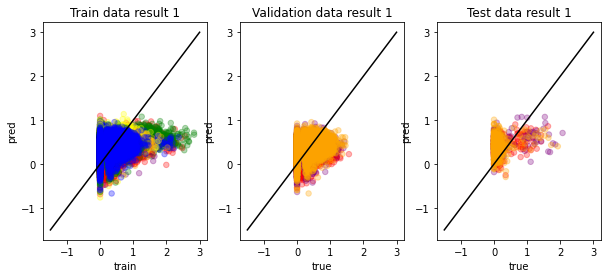

Epoch  100 Train_loss:  0.2144975  Validation_loss:  0.21327117  Test_loss:  0.20847924
Epoch  200 Train_loss:  0.20481935  Validation_loss:  0.20540082  Test_loss:  0.19894429
Epoch  300 Train_loss:  0.20049272  Validation_loss:  0.20186296  Test_loss:  0.19731276
Epoch  400 Train_loss:  0.19689642  Validation_loss:  0.19868666  Test_loss:  0.18979391
Epoch  500 Train_loss:  0.19488569  Validation_loss:  0.19697535  Test_loss:  0.19236104
Epoch  600 Train_loss:  0.19307826  Validation_loss:  0.19535261  Test_loss:  0.18922594
Epoch  700 Train_loss:  0.19196133  Validation_loss:  0.194302  Test_loss:  0.19141982
Epoch  800 Train_loss:  0.19085854  Validation_loss:  0.19330648  Test_loss:  0.19086744
Epoch  900 Train_loss:  0.18989804  Validation_loss:  0.19251634  Test_loss:  0.18898833
Epoch  1000 Train_loss:  0.18909717  Validation_loss:  0.19183435  Test_loss:  0.18991394


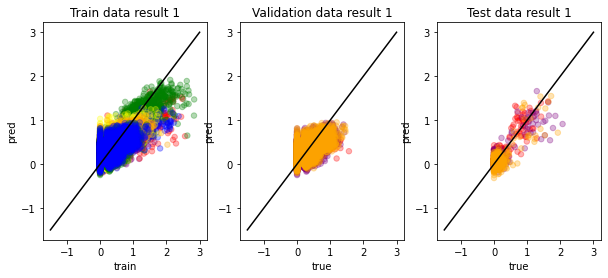

Epoch  1100 Train_loss:  0.18842985  Validation_loss:  0.1911852  Test_loss:  0.19051403
Epoch  1200 Train_loss:  0.18780984  Validation_loss:  0.19060944  Test_loss:  0.19061737
Epoch  1300 Train_loss:  0.18756478  Validation_loss:  0.19030035  Test_loss:  0.19325039
Epoch  1400 Train_loss:  0.18671706  Validation_loss:  0.18955806  Test_loss:  0.19145623
Epoch  1500 Train_loss:  0.18623318  Validation_loss:  0.18912788  Test_loss:  0.19015723
Epoch  1600 Train_loss:  0.18597059  Validation_loss:  0.18889014  Test_loss:  0.19343863
Epoch  1700 Train_loss:  0.1853834  Validation_loss:  0.18828052  Test_loss:  0.19312039
Epoch  1800 Train_loss:  0.18475138  Validation_loss:  0.18783998  Test_loss:  0.19100831
Epoch  1900 Train_loss:  0.18447004  Validation_loss:  0.18747978  Test_loss:  0.1930598
Epoch  2000 Train_loss:  0.1838631  Validation_loss:  0.18693747  Test_loss:  0.19089137


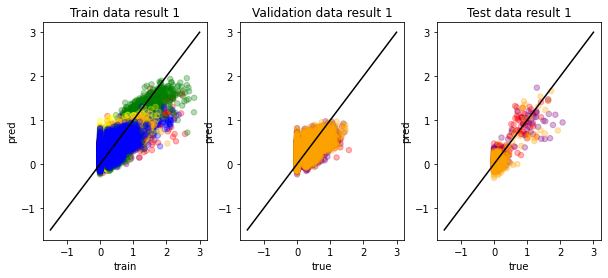

Epoch  2100 Train_loss:  0.18345784  Validation_loss:  0.18657848  Test_loss:  0.19081932
Epoch  2200 Train_loss:  0.18317993  Validation_loss:  0.1862243  Test_loss:  0.19382586
Epoch  2300 Train_loss:  0.18246114  Validation_loss:  0.18569061  Test_loss:  0.19170022
Epoch  2400 Train_loss:  0.18202202  Validation_loss:  0.18523909  Test_loss:  0.19263633
Epoch  2500 Train_loss:  0.1815408  Validation_loss:  0.18478523  Test_loss:  0.19225132
Epoch  2600 Train_loss:  0.1810721  Validation_loss:  0.1844658  Test_loss:  0.19090657
Epoch  2700 Train_loss:  0.18058994  Validation_loss:  0.1839066  Test_loss:  0.19282806
Epoch  2800 Train_loss:  0.18003674  Validation_loss:  0.18351457  Test_loss:  0.19112177
Epoch  2900 Train_loss:  0.17956014  Validation_loss:  0.18308859  Test_loss:  0.1907274
Epoch  3000 Train_loss:  0.17894542  Validation_loss:  0.18247949  Test_loss:  0.19221261


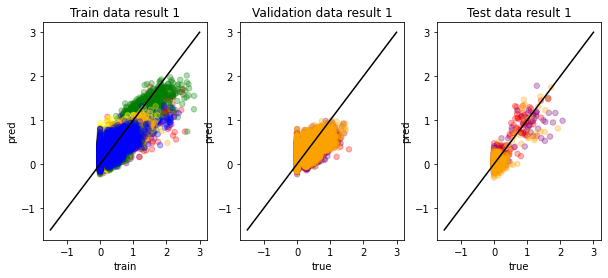

Epoch  3100 Train_loss:  0.17836156  Validation_loss:  0.18200387  Test_loss:  0.19142042
Epoch  3200 Train_loss:  0.1777958  Validation_loss:  0.18146266  Test_loss:  0.19216862
Epoch  3300 Train_loss:  0.17737344  Validation_loss:  0.18106724  Test_loss:  0.19301896
Epoch  3400 Train_loss:  0.17706025  Validation_loss:  0.18071334  Test_loss:  0.19422314
Epoch  3500 Train_loss:  0.17596556  Validation_loss:  0.17983657  Test_loss:  0.19130339
Epoch  3600 Train_loss:  0.17538714  Validation_loss:  0.1792809  Test_loss:  0.19063796
Epoch  3700 Train_loss:  0.17467107  Validation_loss:  0.1786531  Test_loss:  0.19136979
Epoch  3800 Train_loss:  0.17399874  Validation_loss:  0.1780282  Test_loss:  0.19104017
Epoch  3900 Train_loss:  0.1733317  Validation_loss:  0.17743857  Test_loss:  0.19112675
Epoch  4000 Train_loss:  0.17263803  Validation_loss:  0.17679402  Test_loss:  0.19138004


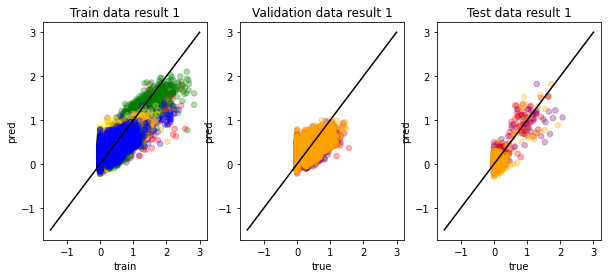

Epoch  4100 Train_loss:  0.17190547  Validation_loss:  0.17615668  Test_loss:  0.19073755
Epoch  4200 Train_loss:  0.17117748  Validation_loss:  0.17553079  Test_loss:  0.19068687
Epoch  4300 Train_loss:  0.1707312  Validation_loss:  0.17501038  Test_loss:  0.19234194
Epoch  4400 Train_loss:  0.17017955  Validation_loss:  0.1744929  Test_loss:  0.19299337
Epoch  4500 Train_loss:  0.16889703  Validation_loss:  0.17347047  Test_loss:  0.19054392
Epoch  4600 Train_loss:  0.16814746  Validation_loss:  0.1728342  Test_loss:  0.19034761
Epoch  4700 Train_loss:  0.16741623  Validation_loss:  0.17213869  Test_loss:  0.1900218
Epoch  4800 Train_loss:  0.16652866  Validation_loss:  0.17132768  Test_loss:  0.19039598
Epoch  4900 Train_loss:  0.16566129  Validation_loss:  0.1705195  Test_loss:  0.19022906
Epoch  5000 Train_loss:  0.16499504  Validation_loss:  0.16993822  Test_loss:  0.19021092


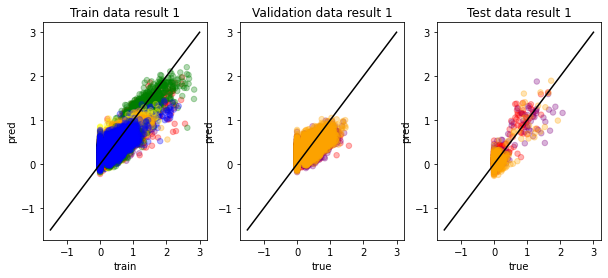

Epoch  5100 Train_loss:  0.16395377  Validation_loss:  0.16897699  Test_loss:  0.19029154
Epoch  5200 Train_loss:  0.1631348  Validation_loss:  0.16827214  Test_loss:  0.1904255
Epoch  5300 Train_loss:  0.16214082  Validation_loss:  0.16732122  Test_loss:  0.19130786
Epoch  5400 Train_loss:  0.16124679  Validation_loss:  0.16650282  Test_loss:  0.19061482
Epoch  5500 Train_loss:  0.16023603  Validation_loss:  0.16560195  Test_loss:  0.19102913
Epoch  5600 Train_loss:  0.15948324  Validation_loss:  0.16487736  Test_loss:  0.19210975
Epoch  5700 Train_loss:  0.15828663  Validation_loss:  0.16384965  Test_loss:  0.19148795
Epoch  5800 Train_loss:  0.15737177  Validation_loss:  0.16295098  Test_loss:  0.19197015
Epoch  5900 Train_loss:  0.15627009  Validation_loss:  0.16198605  Test_loss:  0.1918237
Epoch  6000 Train_loss:  0.15524949  Validation_loss:  0.16101609  Test_loss:  0.19218744


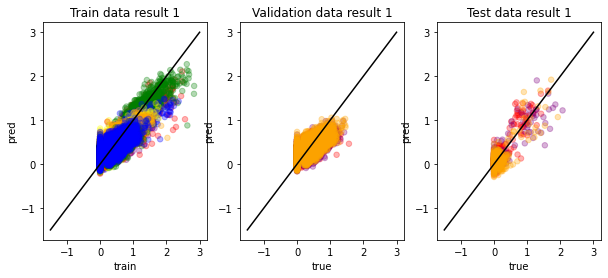

Epoch  6100 Train_loss:  0.15419611  Validation_loss:  0.16004285  Test_loss:  0.19200005
Epoch  6200 Train_loss:  0.15311345  Validation_loss:  0.1590648  Test_loss:  0.19246781
Epoch  6300 Train_loss:  0.15254037  Validation_loss:  0.15835539  Test_loss:  0.19406646
Epoch  6400 Train_loss:  0.15092716  Validation_loss:  0.15697803  Test_loss:  0.19294263
Epoch  6500 Train_loss:  0.14983812  Validation_loss:  0.15594152  Test_loss:  0.19273335
Epoch  6600 Train_loss:  0.14864409  Validation_loss:  0.15484194  Test_loss:  0.19321932
Epoch  6700 Train_loss:  0.14752047  Validation_loss:  0.15377301  Test_loss:  0.19320445
Epoch  6800 Train_loss:  0.1463017  Validation_loss:  0.15262358  Test_loss:  0.1936322
Epoch  6900 Train_loss:  0.14509968  Validation_loss:  0.15148515  Test_loss:  0.19395271
Epoch  7000 Train_loss:  0.14399745  Validation_loss:  0.1503613  Test_loss:  0.19498712


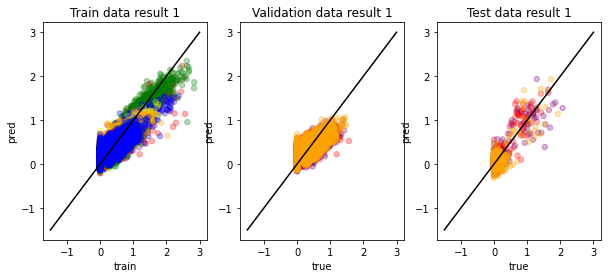

Epoch  7100 Train_loss:  0.14302333  Validation_loss:  0.14937922  Test_loss:  0.19585311
Epoch  7200 Train_loss:  0.1414043  Validation_loss:  0.14793625  Test_loss:  0.19506405
Epoch  7300 Train_loss:  0.14016816  Validation_loss:  0.14670034  Test_loss:  0.19512007
Epoch  7400 Train_loss:  0.1389299  Validation_loss:  0.14553297  Test_loss:  0.19542293
Epoch  7500 Train_loss:  0.1375776  Validation_loss:  0.1442134  Test_loss:  0.19577613
Epoch  7600 Train_loss:  0.13628137  Validation_loss:  0.1429568  Test_loss:  0.19656238
Epoch  7700 Train_loss:  0.13498753  Validation_loss:  0.14168675  Test_loss:  0.19647446
Epoch  7800 Train_loss:  0.13364197  Validation_loss:  0.14038683  Test_loss:  0.19693017
Epoch  7900 Train_loss:  0.13238744  Validation_loss:  0.1391017  Test_loss:  0.19780762
Epoch  8000 Train_loss:  0.13102782  Validation_loss:  0.1377605  Test_loss:  0.1978722


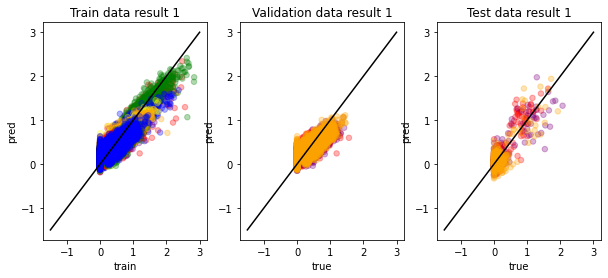

Epoch  8100 Train_loss:  0.12957183  Validation_loss:  0.13635385  Test_loss:  0.19799957
Epoch  8200 Train_loss:  0.12825851  Validation_loss:  0.13503285  Test_loss:  0.19829662
Epoch  8300 Train_loss:  0.12681013  Validation_loss:  0.13361868  Test_loss:  0.19840133
Epoch  8400 Train_loss:  0.1254386  Validation_loss:  0.13224159  Test_loss:  0.19891892
Epoch  8500 Train_loss:  0.12424656  Validation_loss:  0.13099091  Test_loss:  0.19965008
Epoch  8600 Train_loss:  0.12294627  Validation_loss:  0.12972881  Test_loss:  0.19911991
Epoch  8700 Train_loss:  0.12130989  Validation_loss:  0.12809159  Test_loss:  0.20015107
Epoch  8800 Train_loss:  0.11984109  Validation_loss:  0.12665564  Test_loss:  0.20005856
Epoch  8900 Train_loss:  0.11860409  Validation_loss:  0.12539676  Test_loss:  0.20021443
Epoch  9000 Train_loss:  0.11700414  Validation_loss:  0.123791926  Test_loss:  0.20095053


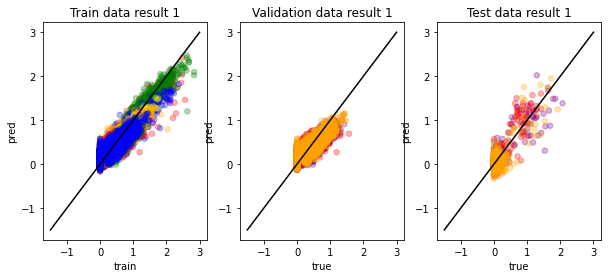

Epoch  9100 Train_loss:  0.115584135  Validation_loss:  0.122372806  Test_loss:  0.20112313
Epoch  9200 Train_loss:  0.1142584  Validation_loss:  0.12098537  Test_loss:  0.20156987
Epoch  9300 Train_loss:  0.11317542  Validation_loss:  0.119823255  Test_loss:  0.20127799
Epoch  9400 Train_loss:  0.11179843  Validation_loss:  0.118424304  Test_loss:  0.20157342
Epoch  9500 Train_loss:  0.10997813  Validation_loss:  0.116685696  Test_loss:  0.20294295
Epoch  9600 Train_loss:  0.10856236  Validation_loss:  0.11524411  Test_loss:  0.20283309
Epoch  9700 Train_loss:  0.1073091  Validation_loss:  0.11395741  Test_loss:  0.20268375
Epoch  9800 Train_loss:  0.105751045  Validation_loss:  0.11239421  Test_loss:  0.20337778
Epoch  9900 Train_loss:  0.10438022  Validation_loss:  0.1110007  Test_loss:  0.20347358
Epoch  10000 Train_loss:  0.10319897  Validation_loss:  0.10972831  Test_loss:  0.20349512


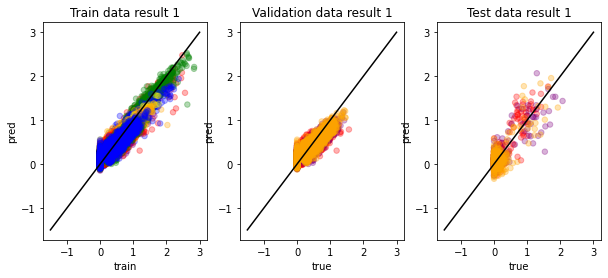

Epoch  10100 Train_loss:  0.10162813  Validation_loss:  0.10816446  Test_loss:  0.20423023
Epoch  10200 Train_loss:  0.1002949  Validation_loss:  0.10679901  Test_loss:  0.20484827
Epoch  10300 Train_loss:  0.09914145  Validation_loss:  0.105601266  Test_loss:  0.20452425
Epoch  10400 Train_loss:  0.09864511  Validation_loss:  0.10487938  Test_loss:  0.20476218
Epoch  10500 Train_loss:  0.0965178  Validation_loss:  0.102889754  Test_loss:  0.20510027
Epoch  10600 Train_loss:  0.09503961  Validation_loss:  0.10138889  Test_loss:  0.20527405
Epoch  10700 Train_loss:  0.09358482  Validation_loss:  0.099939525  Test_loss:  0.20578216
Epoch  10800 Train_loss:  0.09227827  Validation_loss:  0.09858998  Test_loss:  0.20614389
Epoch  10900 Train_loss:  0.09104269  Validation_loss:  0.09731784  Test_loss:  0.20619626
Epoch  11000 Train_loss:  0.08973807  Validation_loss:  0.09597974  Test_loss:  0.20703174


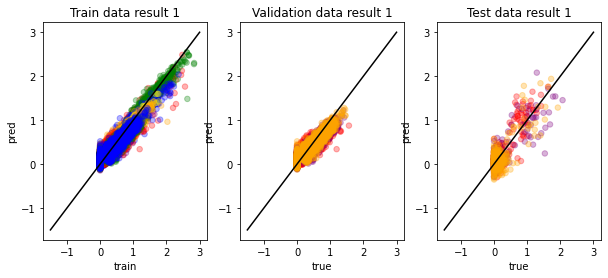

Epoch  11100 Train_loss:  0.08850412  Validation_loss:  0.09470541  Test_loss:  0.20718282
Epoch  11200 Train_loss:  0.08734168  Validation_loss:  0.093484536  Test_loss:  0.20774788
Epoch  11300 Train_loss:  0.08701734  Validation_loss:  0.09294154  Test_loss:  0.20699647
Epoch  11400 Train_loss:  0.084868774  Validation_loss:  0.09093828  Test_loss:  0.20797546
Epoch  11500 Train_loss:  0.08371801  Validation_loss:  0.08979463  Test_loss:  0.2076342
Epoch  11600 Train_loss:  0.08265234  Validation_loss:  0.08860433  Test_loss:  0.20870109
Epoch  11700 Train_loss:  0.081301816  Validation_loss:  0.08727119  Test_loss:  0.20765159
Epoch  11800 Train_loss:  0.08007807  Validation_loss:  0.0860431  Test_loss:  0.20826337
Epoch  11900 Train_loss:  0.079386145  Validation_loss:  0.08518444  Test_loss:  0.20959377
Epoch  12000 Train_loss:  0.07781672  Validation_loss:  0.0837106  Test_loss:  0.20873113


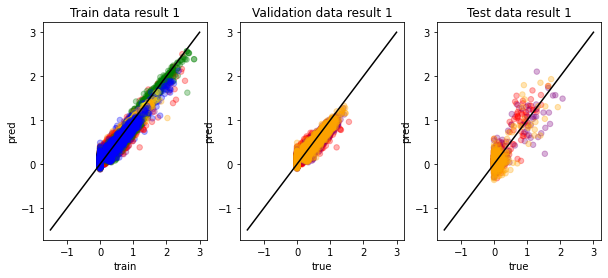

Epoch  12100 Train_loss:  0.0767158  Validation_loss:  0.082568355  Test_loss:  0.2087066
Epoch  12200 Train_loss:  0.07571946  Validation_loss:  0.081509225  Test_loss:  0.20929876
Epoch  12300 Train_loss:  0.07455193  Validation_loss:  0.080350794  Test_loss:  0.20915778
Epoch  12400 Train_loss:  0.07369585  Validation_loss:  0.07940793  Test_loss:  0.20986761
Epoch  12500 Train_loss:  0.07257974  Validation_loss:  0.07826893  Test_loss:  0.20930053
Epoch  12600 Train_loss:  0.071588695  Validation_loss:  0.07722874  Test_loss:  0.21011394
Epoch  12700 Train_loss:  0.07052333  Validation_loss:  0.07615319  Test_loss:  0.2099621
Epoch  12800 Train_loss:  0.069504015  Validation_loss:  0.07511508  Test_loss:  0.20982118
Epoch  12900 Train_loss:  0.068593815  Validation_loss:  0.07415067  Test_loss:  0.21018314
Epoch  13000 Train_loss:  0.06772222  Validation_loss:  0.07322617  Test_loss:  0.21074043


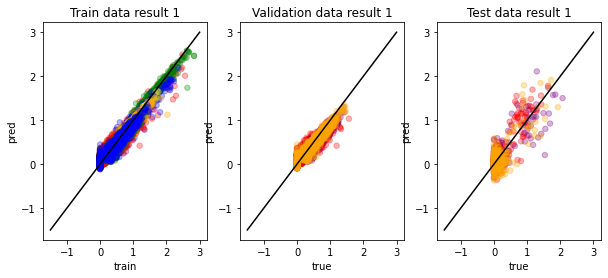

Epoch  13100 Train_loss:  0.06657195  Validation_loss:  0.07211635  Test_loss:  0.210381
Epoch  13200 Train_loss:  0.06569666  Validation_loss:  0.07119829  Test_loss:  0.2103291
Epoch  13300 Train_loss:  0.064846195  Validation_loss:  0.07028906  Test_loss:  0.21094982
Epoch  13400 Train_loss:  0.06398052  Validation_loss:  0.06943268  Test_loss:  0.2106183
Epoch  13500 Train_loss:  0.063016824  Validation_loss:  0.06843119  Test_loss:  0.2107236
Epoch  13600 Train_loss:  0.06222321  Validation_loss:  0.06760901  Test_loss:  0.21060923
Epoch  13700 Train_loss:  0.061327506  Validation_loss:  0.06669943  Test_loss:  0.21111679
Epoch  13800 Train_loss:  0.06058508  Validation_loss:  0.0658982  Test_loss:  0.21092273
Epoch  13900 Train_loss:  0.05971073  Validation_loss:  0.06501261  Test_loss:  0.21130215
Epoch  14000 Train_loss:  0.058882236  Validation_loss:  0.06415928  Test_loss:  0.21133153


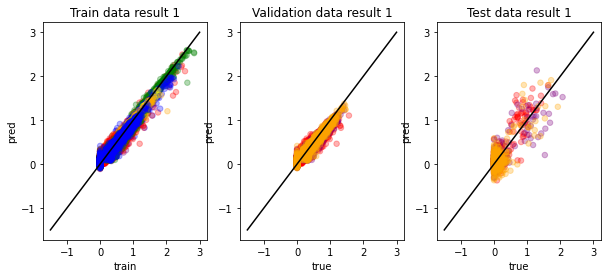

Epoch  14100 Train_loss:  0.058081564  Validation_loss:  0.063348934  Test_loss:  0.21171306
Epoch  14200 Train_loss:  0.057334162  Validation_loss:  0.062569514  Test_loss:  0.21172246
Epoch  14300 Train_loss:  0.056588493  Validation_loss:  0.061796423  Test_loss:  0.21165456
Epoch  14400 Train_loss:  0.055922814  Validation_loss:  0.06107484  Test_loss:  0.21203193
Epoch  14500 Train_loss:  0.055725377  Validation_loss:  0.060732953  Test_loss:  0.21271023
Epoch  14600 Train_loss:  0.05461746  Validation_loss:  0.059693404  Test_loss:  0.21133022
Epoch  14700 Train_loss:  0.05373613  Validation_loss:  0.058840528  Test_loss:  0.21180011
Epoch  14800 Train_loss:  0.053183235  Validation_loss:  0.05824157  Test_loss:  0.21150263
Epoch  14900 Train_loss:  0.052444566  Validation_loss:  0.057458233  Test_loss:  0.21199122
Epoch  15000 Train_loss:  0.051727362  Validation_loss:  0.056757126  Test_loss:  0.21205536


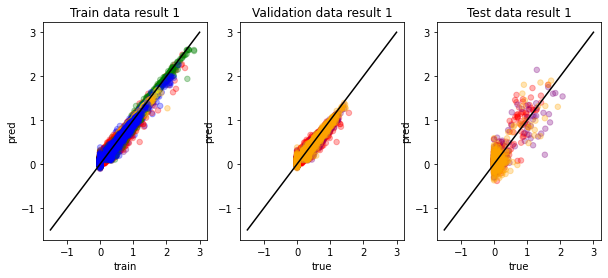

Epoch  15100 Train_loss:  0.05115628  Validation_loss:  0.056141384  Test_loss:  0.21163459
Epoch  15200 Train_loss:  0.050645243  Validation_loss:  0.055554327  Test_loss:  0.21235465


KeyboardInterrupt: 

In [40]:
num_epochs = 50000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)